In [ ]:
!pip install qiskit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *
from qiskit import ClassicalRegister

In [ ]:
QC_outputs = ['000', '001', '010', '011', '100', '101', '110', '111']

In [ ]:
# Defines the quantum circuit so we can use it (since hybrids have quantum)
class QuantumCircuit:
  #This is the initialization
  def __init__(self, n_qubits, backend, shots):
    #Define how many lanes we want
    self._circuit = qiskit.QuantumCircuit(n_qubits)

    #Just a list of 0 to the number of qubits... Just useful so we can just define the circuit (with all it's little parts super quickly)
    all_qubits = [i for i in range(n_qubits)]
    #Kind of like a placeholder variable so we can fill it in later
    self.theta_0 = qiskit.circuit.Parameter('theta0')
    self.theta_1 = qiskit.circuit.Parameter('theta1')
    self.theta_2 = qiskit.circuit.Parameter('theta2')
    self.theta_3 = qiskit.circuit.Parameter('theta3')
    self.theta_4 = qiskit.circuit.Parameter('theta4')
    self.theta_5 = qiskit.circuit.Parameter('theta5')
    self.theta_6 = qiskit.circuit.Parameter('theta6')

    #Shove in the Hardav gate, a barrier (visual), and a rotation about the y plane of theta degrees
    self._circuit.h(all_qubits)
    self._circuit.barrier()
    self._circuit.ry(self.theta_0, all_qubits)
    #Now comes the custom thing for 3 specifically
    self._circuit.cz(0,1)
    self._circuit.cz(1,2)
    self._circuit.ry(self.theta_1, 0)
    self._circuit.ry(self.theta_2, 1)
    self._circuit.ry(self.theta_3, 2)
    self._circuit.cz(0,1)
    self._circuit.cz(1,2)
    self._circuit.ry(self.theta_4, 0)
    self._circuit.ry(self.theta_5, 1)
    self._circuit.ry(self.theta_6, 2)

    self._circuit.measure_all()

    #save these varaibles for later so we don't have to call them again during the forwarding
    self.backend = backend
    self.shots = shots
  
  #forwarding through the quantum circuit
  def run(self, thetas):
    #prep the execution. Link to circuit, Define backend and number of shots... And then fill in the placeholder variable (theta) with the thing we pass through when we forward
    job = qiskit.execute(self._circuit,
                         self.backend,
                         shots = self.shots,
                         parameter_binds = [{self.theta_0: thetas[0],
                                             self.theta_1: thetas[1],
                                             self.theta_2: thetas[2],
                                             self.theta_3: thetas[3],
                                             self.theta_4: thetas[4],
                                             self.theta_5: thetas[5],
                                             self.theta_6: thetas[6],}]) # Might have to change this when multi layer
    
    #execution
    counts = job.result().get_counts(self._circuit)

    expects = np.zeros(8)
    for k in range(8):
      key = QC_outputs[k]
      perc = counts.get(key, 0) /self.shots
      expects[k] = perc
    return expects

In [ ]:
sim = qiskit.Aer.get_backend('qasm_simulator')

test_circuit = QuantumCircuit(3, sim, 100000)

In [ ]:
test_circuit.run([1,2,1,4,5,6,8])

test_circuit._circuit.draw()

┌───┐ ░ ┌────────────┐   ┌────────────┐                 ┌────────────┐»
   q_0: ┤ H ├─░─┤ RY(theta0) ├─■─┤ RY(theta1) ├───────────────■─┤ RY(theta4) ├»
        ├───┤ ░ ├────────────┤ │ └────────────┘┌────────────┐ │ └────────────┘»
   q_1: ┤ H ├─░─┤ RY(theta0) ├─■───────■───────┤ RY(theta2) ├─■───────■───────»
        ├───┤ ░ ├────────────┤         │       ├────────────┤         │       »
   q_2: ┤ H ├─░─┤ RY(theta0) ├─────────■───────┤ RY(theta3) ├─────────■───────»
        └───┘ ░ └────────────┘                 └────────────┘                 »
meas: 3/══════════════════════════════════════════════════════════════════════»
                                                                              »
«                       ░ ┌─┐      
«   q_0: ───────────────░─┤M├──────
«        ┌────────────┐ ░ └╥┘┌─┐   
«   q_1: ┤ RY(theta5) ├─░──╫─┤M├───
«        ├────────────┤ ░  ║ └╥┘┌─┐
«   q_2: ┤ RY(theta6) ├─░──╫──╫─┤M├
«        └────────────┘ ░  ║  ║ └╥┘
«meas: 3/══════════════════╩══╩══╩═
«                          0  1  2

In [ ]:
#This class defines what our hybrid layer does. It allows it to go forward, and also backprop
class HybridFunction(Function):

  @staticmethod
  def forward(ctx, input, quantum_circuit, shift):
    ctx.shift = shift
    ctx.quantum_circuit = quantum_circuit

    parameter = []

    for x in input:
      for y in x:
        parameter.append(float(y))
    # print(parameter)

    #Aka we run the input into our circuit
    expectation_z = ctx.quantum_circuit.run(parameter) #Might need to change this when have multi-layer
    #Shoves to pytorch tesnor
    result = torch.tensor([expectation_z])
    #Save the input and result for backpropagation
    ctx.save_for_backward(input,result)
    #return output
    return result
  
  @staticmethod
  def backward(ctx, grad_output):
    #Regrabing the input and the output
    input, expectation_z = ctx.saved_tensors
    # input_list = np.array(input.tolist())
    # print(input)

    input_list = list(input)[0]
    # print(input_list)

    #AKA if we take our inputs and just add/subtract a tiny amount
    # shift_right = input_list + np.ones(input_list.shape) * ctx.shift
    # shift_left = input_list - np.ones(input_list.shape) * ctx.shift
    # print(shift_right)
    # print(shift_left)

    #A list of all the gradients
    gradients = torch.Tensor()

    #We're going to go through the inputs and then calculate the gradient for each one
    for i in range(7):
      shift_right = np.array(input_list.detach().clone())
      shift_left = np.array(input_list.detach().clone())
      shift_right[i] = shift_right[i] + ctx.shift
      shift_left[i] = shift_left[i] - ctx.shift

      #So we take the shifted ones and just compute it 
      expectation_right = ctx.quantum_circuit.run(shift_right)
      expectation_left  = ctx.quantum_circuit.run(shift_left)
      #Gradient = appox the difference (division by 2*shift isn't necessary since it'll just be a scaled version (which can be counteracted by lr))
      gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
      #Append the gradient to the meta list
      gradients  = torch.cat((gradients, gradient.float()))
      # print(gradient.shape)
      # print(gradients.shape)
    
    #Turn it into np and transpose it
    # print(gradients.shape)

    # gradients = np.array(gradients)
    # print(gradients)
    result = torch.Tensor(gradients)
    result = result.float()
    result = result.T

    # gradients = gradients.T
    # print(result.shape)
    Fixer = grad_output.float()
    Fixer = Fixer.T
    # print(Fixer.shape)

    h = result * Fixer
    # print(h.shape)
    #then return it for backprop
    return h, None, None

# New Section

In [ ]:
#This defines the acutal thing that we're shoving into the NN
class Hybrid(nn.Module):
  #initialization
  def __init__(self, backend, shots, shift):
    super(Hybrid, self).__init__()
    #Define the real quantum circuit that we'll be using for our thing
    self.quantum_circuit = QuantumCircuit(3, backend, shots)
    #Save this guy for alter
    self.shift = shift
  
  #When forwarding
  def forward(self, input):
    return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
#Now we just define the data stuff

n_samples = 1000

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [ ]:
n_samples = 1000

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [ ]:
#The actual one
class Net(nn.Module):
  #Initialization
  def __init__(self):
    super(Net, self).__init__()
    #Defining all the classical layers
    self.classical = nn.Sequential(
        nn.Conv2d(1,6,5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout()
    )
    #Defining the middel part
    self.middel = nn.Sequential(
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,7))
    #Definign the quantum part
    self.quantum = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 1000, np.pi / 2)

    #Defining part 2 of classical (to bring it back down to 1 output)
    self.end = nn.Sequential(
        nn.Linear(8,1),
        nn.Sigmoid()
    )
  
  #For whenever we pass stuff through it
  def forward(self,x):
    #Pass it through each one
    x = self.classical(x)
    x = x.view(1, -1)
    x = self.middel(x)
    theta = x
    # print(x)
    x = self.quantum(x)
    # print(x)
    x = self.end(x.float())
    x = x.view(1, -1)
    # print(x)
    return torch.cat((x, 1-x), -1), theta

In [ ]:
#Define the model, optimzier and loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_func = nn.CrossEntropyLoss()

#Define the epochs and the list (where we plot) the losses
epochs = 1
loss_list = []
thetas = []

In [ ]:
model

Net(
  (classical): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.5, inplace=False)
  )
  (middel): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
  (quantum): Hybrid()
  (end): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# New Section

In [ ]:
#Training mode
model.train()
for epoch in range(epochs):
  #So we can shove it on the loss graph
  total_loss = []
  #Go through the dataloader
  for image, label in train_loader:
    #Set the gradient back to 0
    optimizer.zero_grad()
    #Shove the image through the model
    # try:
    prediction,theta = model(image)
    #Get the loss
    # print(label)
    # print(prediction)
    loss = loss_func(prediction, label)
    #Compute the gradients
    loss.backward()
    #Update parameters
    optimizer.step()
    #Save theta
    thetas.append(theta)
    #Add this loss to the total
    total_loss.append(loss.item())
    # except:
    #   continue
  
  #Shove total loss of epoch to the total loss of the model
  loss_list.append(sum(total_loss) / len(total_loss))
  #Print some readout so we know it's working
  print(loss_list[-1])

0.519454716309905


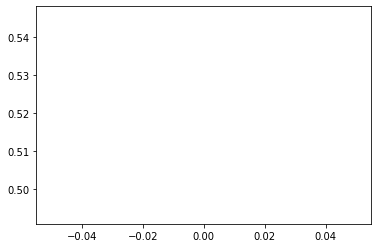

In [ ]:
plt.plot(loss_list)

In [ ]:
thetas[-1]

tensor([[ 0.3651, -1.0659,  1.6011, -1.1961, -0.4254, -1.3957, -0.5281]],
       grad_fn=<AddmmBackward>)

In [ ]:
sim = qiskit.Aer.get_backend('qasm_simulator')

test_circuit = QuantumCircuit(1, sim, 1000)

In [ ]:
test_circuit.run([-1.9])

# test_circuit._circuit.draw()

In [ ]:
#Evaluation mode
model.eval()
#So it doesn't compute gradients
with torch.no_grad():
  correct = 0
  #Go through the test loader
  for image, label in test_loader:
    #Get prediction
    try:
      prediction,theta = model(image)
      #Get the index of the prediction (thus the true prediction of the image)
      true_pred = prediction.argmax(dim=1, keepdim = True)
      #If they're correct add em up
      correct += true_pred.eq(label.view_as(true_pred)).sum().item()
    except:
      continue
  
  print(correct / len(test_loader) * 100)

99.84848484848486


In [ ]:
test_tensor = torch.tensor([ 0.0500,  0.0001,  0.1100,  0.0000,  0.0000, -0.1400,  0.0000, -0.0200])

In [ ]:
test_tensor = [test_tensor]

In [ ]:
gradints = test_tensor.numpy()

gradints = gradints.T

AttributeError: ignored

In [ ]:
gradints

In [ ]:
h = [[ 0.04374691, -0.08862904, -0.08470156, -0.07864326, -0.06539986, -0.0589257, 0.10701392]]

In [ ]:
h[0]

[0.04374691,
 -0.08862904,
 -0.08470156,
 -0.07864326,
 -0.06539986,
 -0.0589257,
 0.10701392]